<a href="https://colab.research.google.com/github/Saultr21/IA-Y-BIGDATA/blob/main/SNS/DengAI/DengAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saúl Tomás Trujillo Rodríguez

### **Paso 1. Importación de Librerías**
Se importan las librerías necesarias para la manipulación de datos, preprocesamiento, selección de características y entrenamiento de modelos de Machine Learning.


In [1]:
!pip install --upgrade xgboost scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


### **Paso 2. Carga de Datos**
Se leen los archivos CSV que contienen los datos de entrenamiento y prueba, y se cargan en `pandas.DataFrame`. Luego, se muestra información básica sobre cada dataset.


In [2]:
import pandas as pd

# Definir las URLs de los archivos en GitHub (RAW)
features_train_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/main/SNS/DengAI/dengue_features_train.csv"
labels_train_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/main/SNS/DengAI/dengue_labels_train.csv"
features_test_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/main/SNS/DengAI/dengue_features_test.csv"

# Cargar los datasets en DataFrames
df_features_train = pd.read_csv(features_train_url)
df_labels_train = pd.read_csv(labels_train_url)
df_features_test = pd.read_csv(features_test_url)

# Mostrar información básica de los datasets
print("Features Train:")
print(df_features_train.info(), "\n")

print("Labels Train:")
print(df_labels_train.info(), "\n")

print("Features Test:")
print(df_features_test.info(), "\n")


Features Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   f

### **Paso 3. Preprocesamiento de Datos**
- Se unen las etiquetas (`total_cases`) al conjunto de entrenamiento.
- Se eliminan columnas irrelevantes (`city`, `year`, `week_start_date`).
- Se manejan valores faltantes imputando la mediana.
- Se normalizan los datos usando `MinMaxScaler` para escalar los valores entre 0 y 1.
- Se convierten los datos escalados en un DataFrame y se agregan las etiquetas de `total_cases`.


In [3]:
df_features_train = pd.read_csv(features_train_url)
df_labels_train = pd.read_csv(labels_train_url)
df_features_test = pd.read_csv(features_test_url)

# Unir las etiquetas al conjunto de entrenamiento
df_train = df_features_train.merge(df_labels_train, on=["city", "year", "weekofyear"])

# Eliminar columnas irrelevantes
drop_columns = ["city", "year", "week_start_date"]
df_train_cleaned = df_train.drop(columns=drop_columns)
df_test_cleaned = df_features_test.drop(columns=drop_columns)

# Manejo de valores faltantes: Imputación con la mediana
df_train_cleaned.fillna(df_train_cleaned.median(), inplace=True)
df_test_cleaned.fillna(df_test_cleaned.median(), inplace=True)

# Normalización de datos (MinMaxScaler)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train_cleaned.drop(columns=["total_cases"]))
scaled_test = scaler.transform(df_test_cleaned)

# Convertir de nuevo a DataFrame
df_train_scaled = pd.DataFrame(scaled_train, columns=df_train_cleaned.columns[:-1])
df_test_scaled = pd.DataFrame(scaled_test, columns=df_test_cleaned.columns)

# Agregar la columna de etiquetas al conjunto de entrenamiento
df_train_scaled["total_cases"] = df_train_cleaned["total_cases"].values

# Mostrar las primeras filas del dataset procesado
df_train_scaled.head()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,0.326923,0.578226,0.614835,0.386418,0.395544,0.031797,0.388291,0.354667,0.314680,0.123457,...,0.381614,0.031797,0.262659,0.086660,0.430091,0.210393,0.174194,0.486239,0.029450,4
1,0.346154,0.629943,0.657063,0.321190,0.359233,0.058423,0.472710,0.441778,0.489213,0.191358,...,0.479668,0.058423,0.418164,0.069133,0.565350,0.163498,0.322581,0.688073,0.015829,5
2,0.365385,0.479441,0.690881,0.311879,0.384430,0.088428,0.548064,0.496000,0.657583,0.166667,...,0.594415,0.088428,0.586900,0.064265,0.565350,0.173638,0.354839,0.743119,0.076201,4
3,0.384615,0.584823,0.770066,0.438912,0.491150,0.039324,0.575260,0.539556,0.643471,0.222222,...,0.552387,0.039324,0.566808,0.073028,0.645897,0.198986,0.425806,0.788991,0.007362,3
4,0.403846,0.658698,0.788882,0.481601,0.509943,0.019252,0.645515,0.593778,0.701541,0.253086,...,0.555396,0.019252,0.628226,0.112950,0.802432,0.429658,0.535484,0.844037,0.010676,6


### **Paso 4. Selección de Características**
- **Correlación de Pearson:** Se seleccionan las variables con una correlación superior a 0.1 con `total_cases`.
- **Eliminación de Baja Varianza:** Se eliminan las características con varianza menor al 1%.
- **SelectKBest (ANOVA F-value):** Se eligen las 10 mejores características según su relevancia con la variable objetivo.
- **Combinación de Métodos:** Se conservan solo las características seleccionadas por ambos métodos.
- **Aplicación al Conjunto de Prueba:** Se filtran los datos de prueba con las mismas características seleccionadas.


In [4]:
# Separar características y variable objetivo
X = df_train_scaled.drop(columns=["total_cases"])
y = df_train_scaled["total_cases"]

# 1. Correlación de Pearson (selección basada en relación con total_cases)
correlation = X.corrwith(y).abs().sort_values(ascending=False)
selected_features_corr = correlation[correlation > 0.1].index.tolist()  # Umbral 0.1

# 2. Eliminación de baja varianza
selector_var = VarianceThreshold(threshold=0.01)  # Umbral 1% de varianza
X_high_var = X.loc[:, selector_var.fit(X).get_support()]

# 3. Selección con SelectKBest (ANOVA F-value)
selector_kbest = SelectKBest(score_func=f_regression, k=10)  # Seleccionamos las 10 mejores
X_kbest = selector_kbest.fit_transform(X_high_var, y)
selected_features_kbest = X_high_var.columns[selector_kbest.get_support()].tolist()

# Combinar las características seleccionadas por ambos métodos
final_selected_features = list(set(selected_features_corr) & set(selected_features_kbest))

# Filtrar el conjunto de datos con las características finales
X_selected = X[final_selected_features]
df_train_selected = X_selected.copy()
df_train_selected["total_cases"] = y  # Agregar la variable objetivo

# Aplicar los mismos filtros al conjunto de prueba
df_test_selected = df_test_scaled[final_selected_features]

# Mostrar las características seleccionadas
print("Características seleccionadas:", final_selected_features)


Características seleccionadas: ['station_diur_temp_rng_c', 'ndvi_ne', 'weekofyear', 'reanalysis_max_air_temp_k', 'reanalysis_tdtr_k', 'ndvi_sw', 'reanalysis_min_air_temp_k', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'station_min_temp_c']


### **Paso 5. Análisis de Correlación**
- Se calcula la **correlación de cada variable con `total_cases`** y se seleccionan aquellas con un valor mayor a 0.1.
- Se genera un **mapa de calor** con las características seleccionadas para visualizar sus relaciones.
- Este análisis ayuda a identificar **variables altamente correlacionadas**, lo que permite reducir la redundancia en los datos.


Matriz de correlación con total_cases:


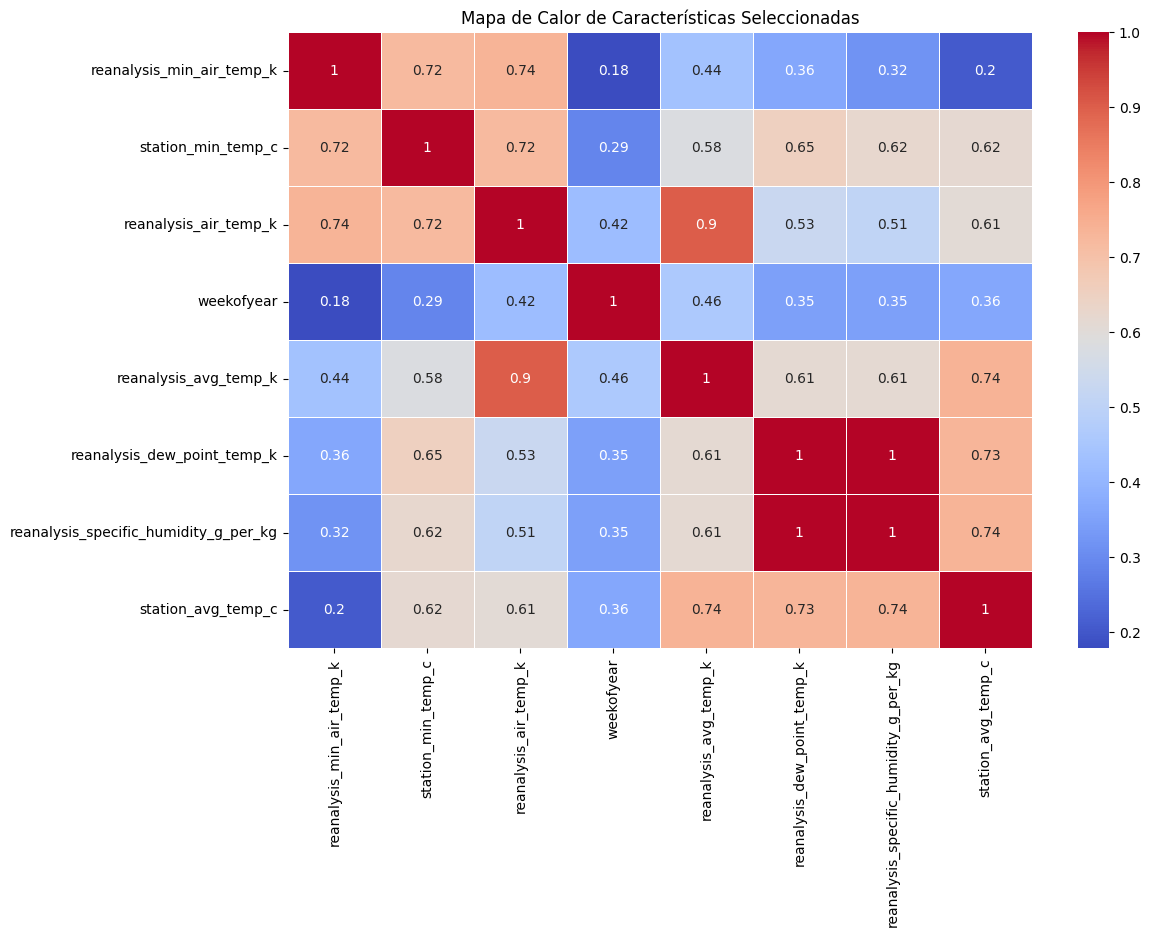

In [5]:
# Matriz de correlación con total_cases
correlation_matrix = X.corrwith(y).sort_values(ascending=False)
print("Matriz de correlación con total_cases:")

# Seleccionar características con correlación significativa (> 0.1)
selected_features_corr = correlation_matrix[correlation_matrix > 0.1].index.tolist()

# Mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(X[selected_features_corr].corr(), cmap="coolwarm", annot=True, linewidths=0.5)
plt.title("Mapa de Calor de Características Seleccionadas")
plt.show()


### **Paso 6. Importancia de Características con Random Forest**
- Se entrena un modelo de **Random Forest Regressor** con 100 árboles para evaluar la importancia de cada característica.
- Se extraen los **valores de importancia de características** y se ordenan de mayor a menor.
- Se genera un **gráfico de barras** con las 15 características más relevantes.
- Finalmente, se seleccionan las **10 características con mayor importancia** para el modelo.


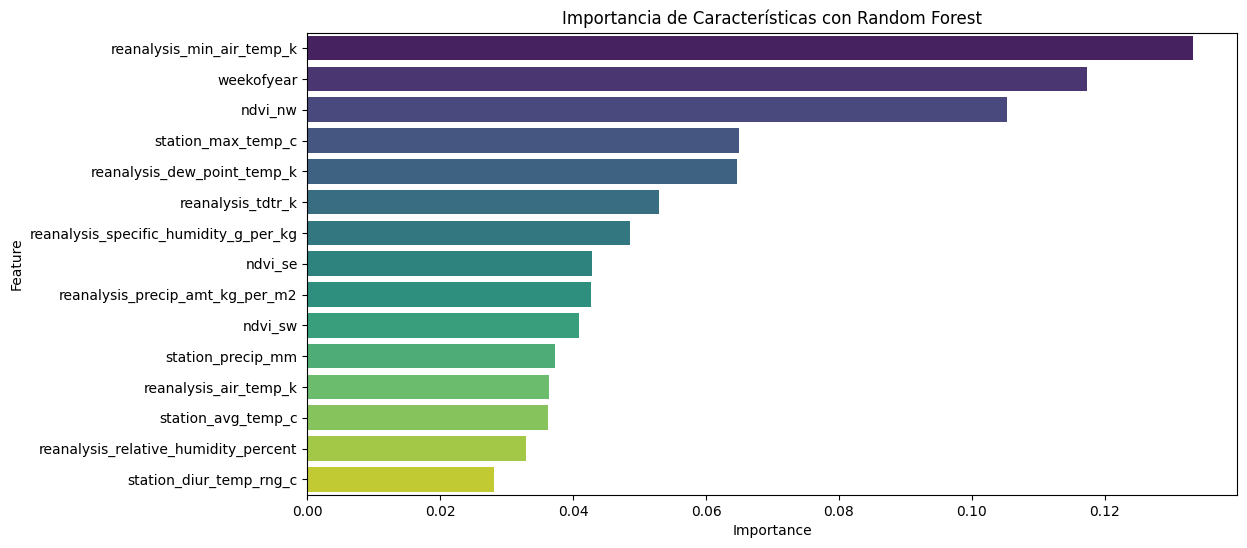

In [6]:
# Entrenar modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Obtener importancia de características
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", hue="Feature", data=importance_df.head(15), palette="viridis", legend=False)
plt.title("Importancia de Características con Random Forest")
plt.show()

# Seleccionar las 10 características más importantes
final_selected_features = importance_df.head(10)["Feature"].tolist()


### **Paso 7. Análisis de Relaciones entre Variables (Pairplot)**
- Se crea un **pairplot** para visualizar la relación entre las 10 características seleccionadas y `total_cases`.
- Se incluyen **gráficos de dispersión** entre las variables y **distribuciones (`kde`) en la diagonal**.
- Este análisis permite identificar **patrones, correlaciones y distribuciones de datos**.


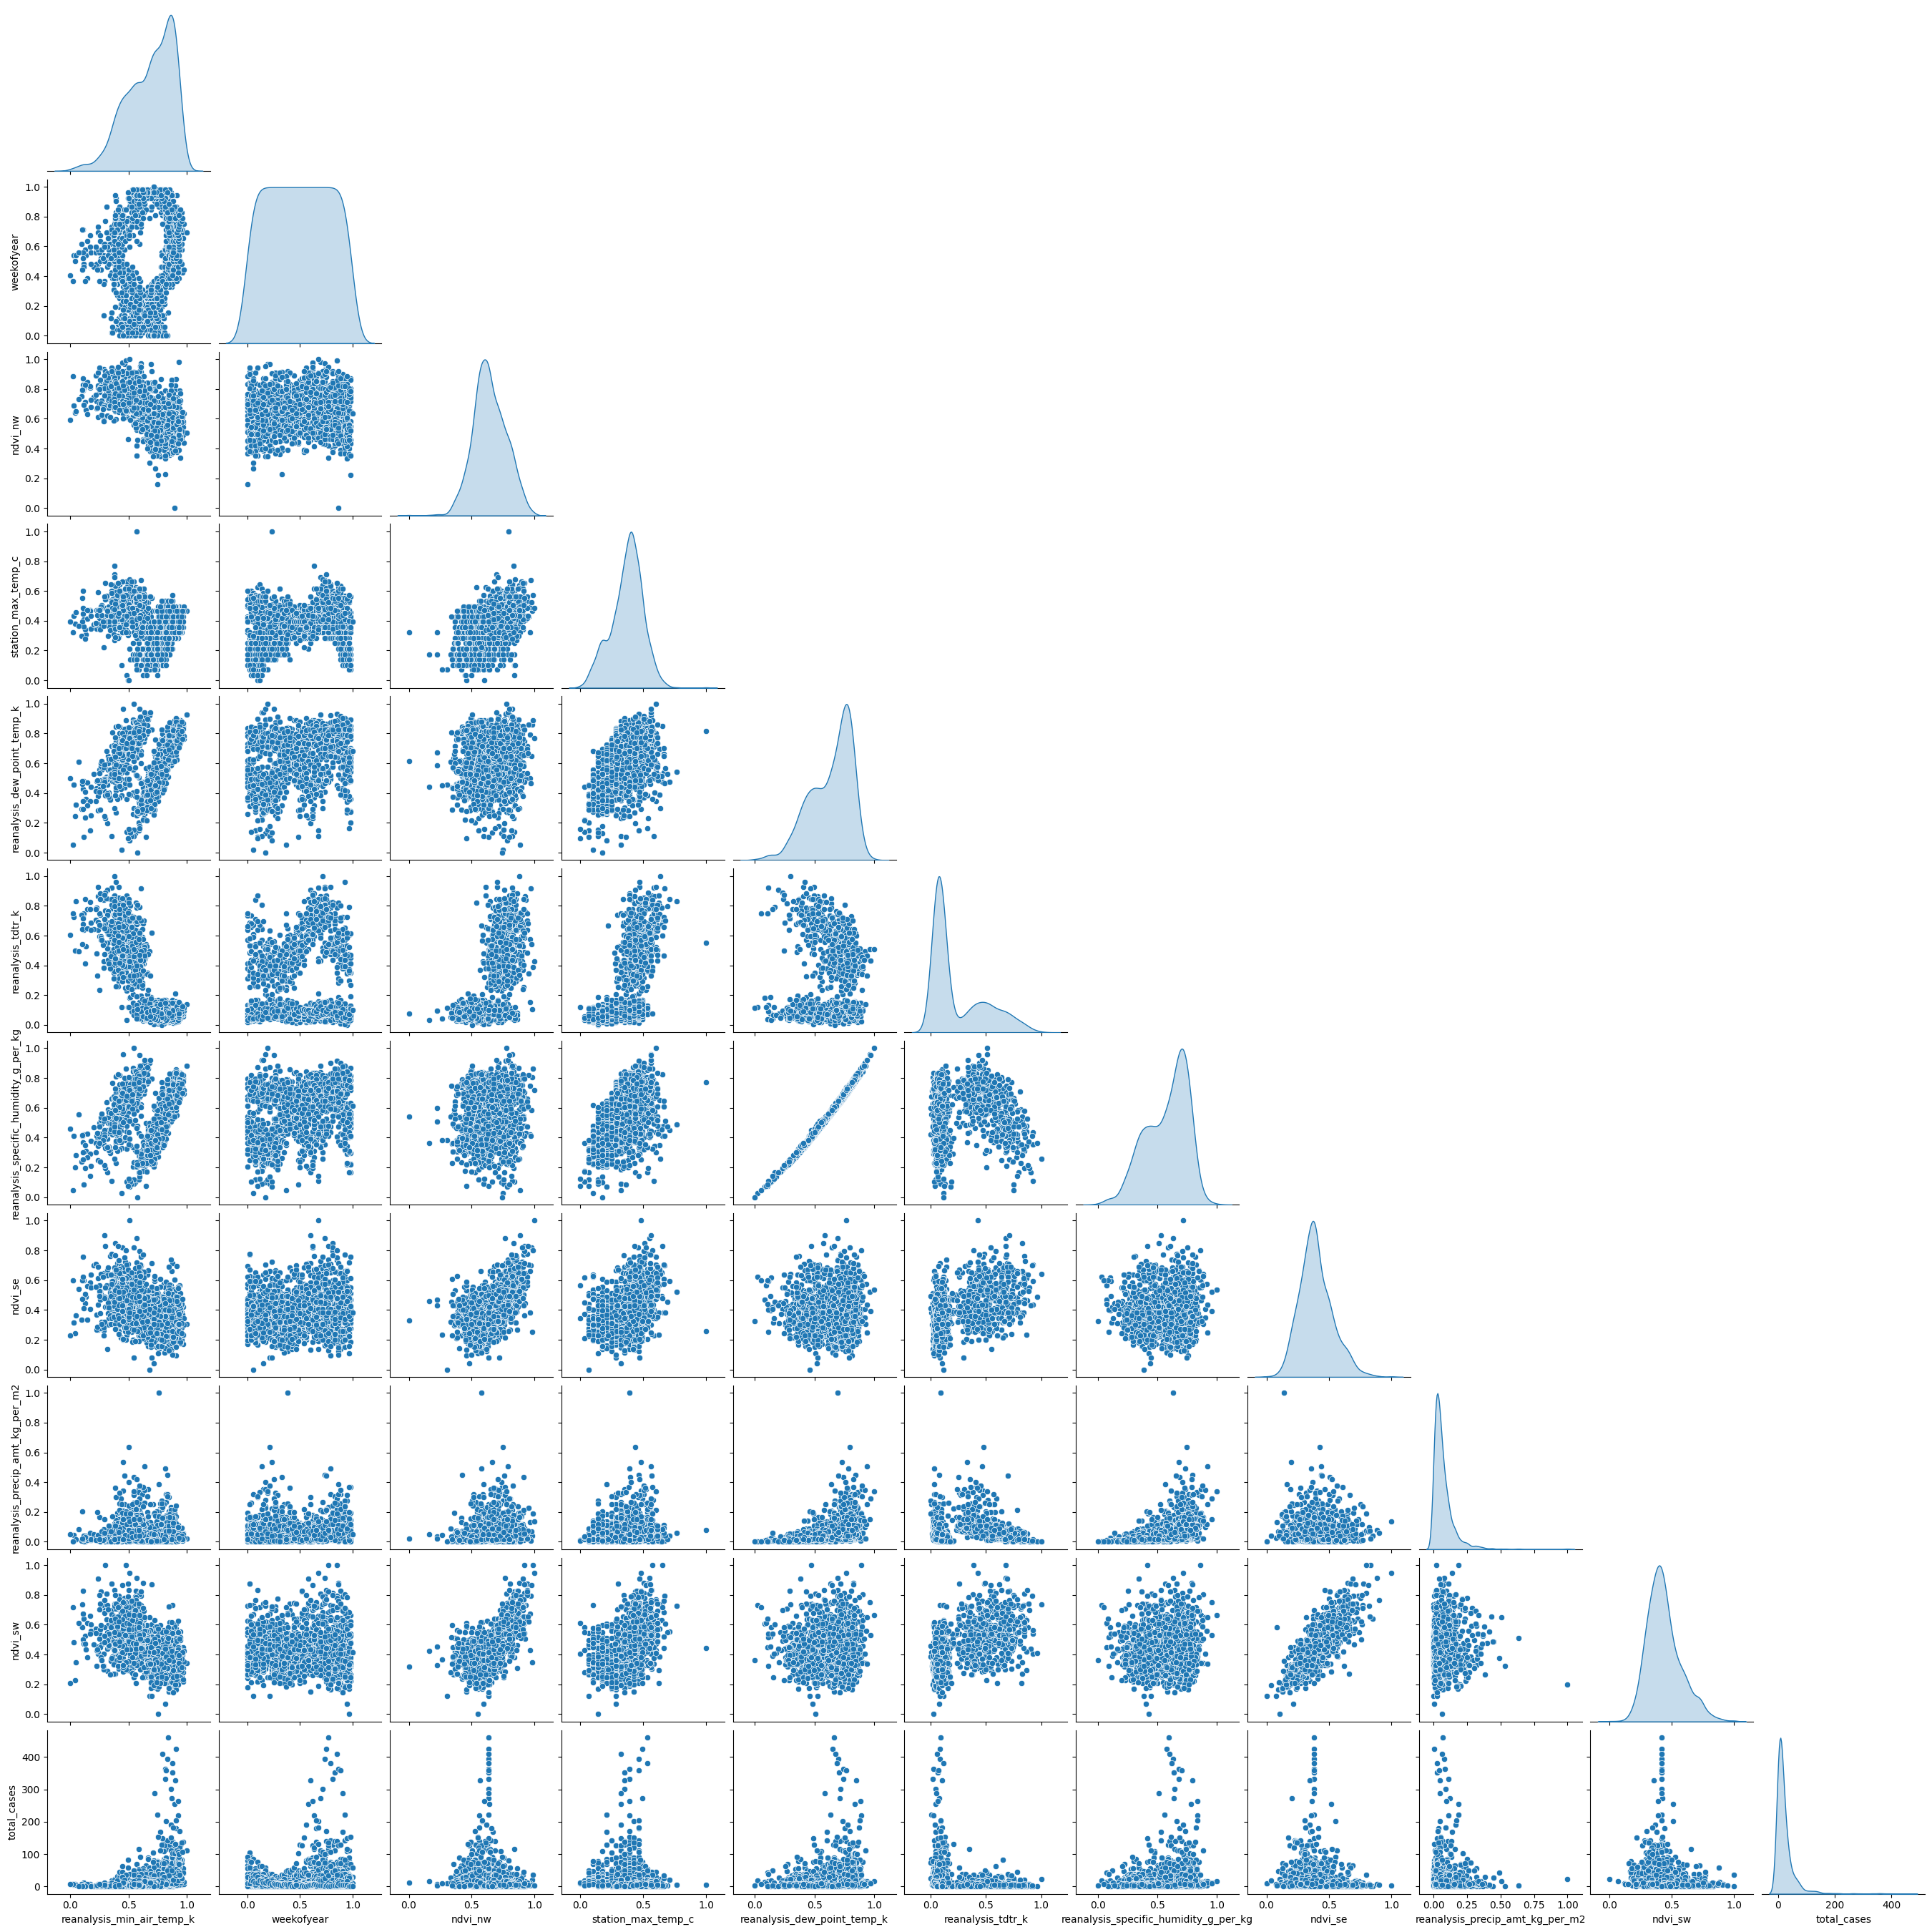

In [7]:
# Pairplot (antes llamada "matriz de confusión")
data = df_train_scaled[final_selected_features + ["total_cases"]]  # Incluir variable objetivo
sns.pairplot(data, diag_kind="kde", corner=True)
plt.show()

### **Paso 8. Comparación de Modelos de Regresión**
- Se definen dos conjuntos de características:
  - **`features_kbest`**: Seleccionadas con `SelectKBest`.
  - **`features_rf`**: Añade `ndvi_nw` según la importancia de `RandomForest`.
- Se dividen los datos en **entrenamiento (80%) y prueba (20%)**.
- Se entrenan y evalúan cuatro modelos:
  - **Regresión Lineal con `KBest` y `RandomForest`**.
  - **RandomForest con `KBest` y `RandomForest`**.
- Se calculan las métricas **RMSE (error cuadrático medio) y R² (coeficiente de determinación)** para comparar el rendimiento de cada modelo.


In [8]:
# Definir conjuntos de características
features_kbest = ['ndvi_ne', 'reanalysis_min_air_temp_k', 'ndvi_sw', 'reanalysis_tdtr_k',
                  'reanalysis_max_air_temp_k', 'reanalysis_air_temp_k', 'weekofyear',
                  'station_min_temp_c', 'station_diur_temp_rng_c', 'reanalysis_avg_temp_k']

features_rf = features_kbest + ['ndvi_nw']  # Añadimos ndvi_nw según RandomForest

# Dividir datos en entrenamiento y prueba
X_train_kbest, X_test_kbest, y_train, y_test = train_test_split(df_train_scaled[features_kbest], y, test_size=0.2, random_state=42)
X_train_rf, X_test_rf, _, _ = train_test_split(df_train_scaled[features_rf], y, test_size=0.2, random_state=42)

# Entrenar modelos con ambos conjuntos de características
models = {
    "Regresión Lineal (KBest)": LinearRegression(),
    "Regresión Lineal (RandomForest)": LinearRegression(),
    "RandomForest (KBest)": RandomForestRegressor(n_estimators=100, random_state=42),
    "RandomForest (RandomForest)": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    if "KBest" in name:
        model.fit(X_train_kbest, y_train)
        y_pred = model.predict(X_test_kbest)
    else:
        model.fit(X_train_rf, y_train)
        y_pred = model.predict(X_test_rf)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R²": r2}

# 🔹 Convertir resultados a DataFrame y mostrar en pantalla
results_df = pd.DataFrame(results).T
print("\n📊 Comparación de Modelos:")
print(results_df)



📊 Comparación de Modelos:
                                      RMSE        R²
Regresión Lineal (KBest)         52.883533  0.128797
Regresión Lineal (RandomForest)  52.762685  0.132774
RandomForest (KBest)             47.271124  0.303902
RandomForest (RandomForest)      45.995456  0.340965


En esta comparación vemos que el mejor modelo es RandomForest (RandomForest), ya que tiene el menor RMSE (45.99) y el mayor R² (0.341).

### **Paso 9. División de Datos en Entrenamiento, Validación y Prueba**
- Se seleccionan las características finales basadas en `RandomForest`.
- Se divide el dataset en tres conjuntos:
  - **70%** para entrenamiento (`X_train`, `y_train`).
  - **15%** para validación (`X_val`, `y_val`).
  - **15%** para prueba (`X_test`, `y_test`).
- Esto permite evaluar el modelo en datos no vistos antes de la prueba final.


In [9]:
# 🔹 Definir las características finales (RandomForest mejoró el rendimiento)
features_final = ['ndvi_ne', 'reanalysis_min_air_temp_k', 'ndvi_sw', 'reanalysis_tdtr_k',
                  'reanalysis_max_air_temp_k', 'reanalysis_air_temp_k', 'weekofyear',
                  'station_min_temp_c', 'station_diur_temp_rng_c', 'reanalysis_avg_temp_k', 'ndvi_nw']

# 🔹 División en Train (70%), Validation (15%) y Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(df_train_scaled[features_final], y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% y 15%

# 🔹 Mostrar tamaños de los conjuntos
print(f"Tamaño de Train: {X_train.shape}")
print(f"Tamaño de Validación: {X_val.shape}")
print(f"Tamaño de Test: {X_test.shape}")

Tamaño de Train: (1019, 11)
Tamaño de Validación: (218, 11)
Tamaño de Test: (219, 11)


### **Paso 10. Evaluación de Modelos Naïve Bayes con Cross Validation**
- Se prueban cuatro modelos de **Naïve Bayes** (`GaussianNB`, `MultinomialNB`, `BernoulliNB`, `ComplementNB`).
- Se usa **validación cruzada (KFold, 5 folds)** para evaluar el rendimiento de cada modelo.
- Se calculan las métricas **R² Score** y **Accuracy** para comparar su desempeño.
- Se genera un **gráfico de barras** con ambas métricas para visualizar cuál modelo funciona mejor.


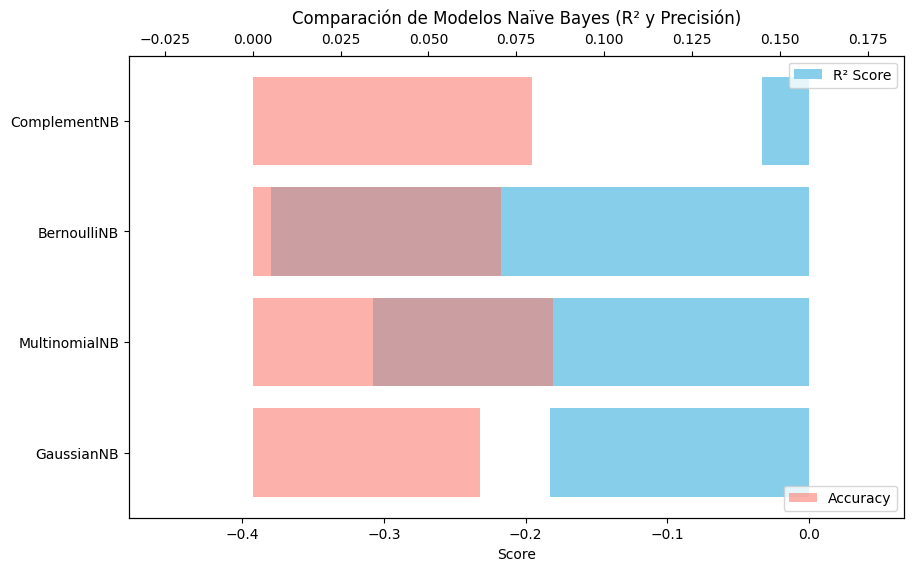


📊 Comparación de Modelos Naïve Bayes:
               R² Score  Accuracy
GaussianNB    -0.182649  0.064778
MultinomialNB -0.307580  0.085376
BernoulliNB   -0.379811  0.070651
ComplementNB  -0.033072  0.079489


In [10]:
# 🔹 Definir los modelos de Naïve Bayes aplicables a datos numéricos
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB()
}
# 🔹 Configurar KFold para evitar el warning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 🔹 Evaluación de cada modelo con Cross Validation (5 folds)
cv_results = {}
for name, model in models.items():
    r2_scores = []
    accuracy_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        # Convertir predicciones a enteros para precisión
        y_pred_int = np.round(y_pred).astype(int)
        # Evaluar R² y Precisión
        r2_scores.append(r2_score(y_val_fold, y_pred))
        accuracy_scores.append(accuracy_score(y_val_fold, y_pred_int))

    # Guardar promedios de R² y Precisión
    cv_results[name] = {"R² Score": np.mean(r2_scores), "Accuracy": np.mean(accuracy_scores)}

# 🔹 Convertir resultados en un DataFrame
results_df = pd.DataFrame(cv_results).T
# 🔹 Graficar resultados
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.barh(results_df.index, results_df["R² Score"], color="skyblue", label="R² Score")
ax1.set_xlabel("Score")
ax1.set_title("Comparación de Modelos Naïve Bayes (R² y Precisión)")
ax1.set_xlim([min(results_df["R² Score"]) - 0.1, max(results_df["R² Score"]) + 0.1])
# Agregar segunda escala para precisión
ax2 = ax1.twiny()
ax2.barh(results_df.index, results_df["Accuracy"], color="salmon", alpha=0.6, label="Accuracy")
ax2.set_xlim([min(results_df["Accuracy"]) - 0.1, max(results_df["Accuracy"]) + 0.1])
# Mostrar leyenda
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")
plt.show()
# 🔹 Mostrar resultados numéricos
print("\n📊 Comparación de Modelos Naïve Bayes:")
print(results_df)

## 📊 Conclusión: Selección del Mejor Modelo de Naïve Bayes

### 🔹 Análisis de Resultados:
| Modelo          | **R² Score** (Mayor es mejor) | **Precisión (Accuracy)** (Mayor es mejor) |
|---------------|-------------------|----------------|
| **GaussianNB**    | -0.1826 ❌ | 0.0648 ❌ |
| **MultinomialNB** | -0.3076 ❌ | 0.0853 ✅ |
| **BernoulliNB**   | -0.3798 ❌ | 0.0706 ❌ |
| **ComplementNB**  | -0.0330 ✅ | 0.0794 🔹 |

### 🔹 ¿Qué significan estos valores?
- **El mejor modelo en R² es `ComplementNB` (-0.033)**.  
  - Aunque sigue siendo **muy bajo**, es el único que **se acerca a 0**, lo que indica que **explica mejor la variabilidad de los datos** comparado con los otros.  
  - Un R² negativo significa que **el modelo es peor que simplemente predecir el promedio de los datos**.  

- **El mejor modelo en precisión (`Accuracy`) es `MultinomialNB` (0.0853)**.  
  - Sin embargo, la precisión es muy baja en general, lo que sugiere que **Naïve Bayes no es adecuado para este problema**.  

### 🔹 **Conclusión Final**
✅ **Si se debe elegir un modelo de Naïve Bayes, `ComplementNB` es la mejor opción**, ya que tiene el **mejor R² Score (-0.0330)**.  


### **Paso 11. Evaluación de Modelos KNN con Cross Validation**
- Se prueba el modelo **K-Nearest Neighbors (KNN)** con diferentes valores de `K` (de 1 a 20).
- Se evalúan **tres métricas de distancia**: `euclidean`, `manhattan` y `minkowski`.
- Se utiliza **validación cruzada (KFold, 5 folds)** para obtener métricas de rendimiento.
- Se comparan los modelos en base a **R² Score (mayor es mejor) y RMSE (menor es mejor)**.
- Se generan **gráficos** para visualizar el efecto de `K` en el rendimiento del modelo.
- Finalmente, se identifica el **mejor modelo** basado en el mayor R² Score.


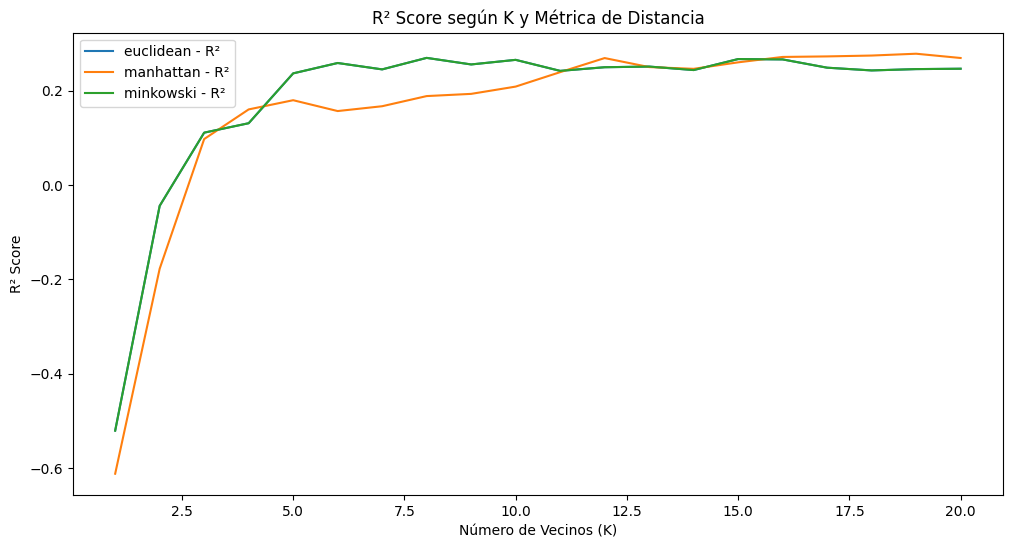

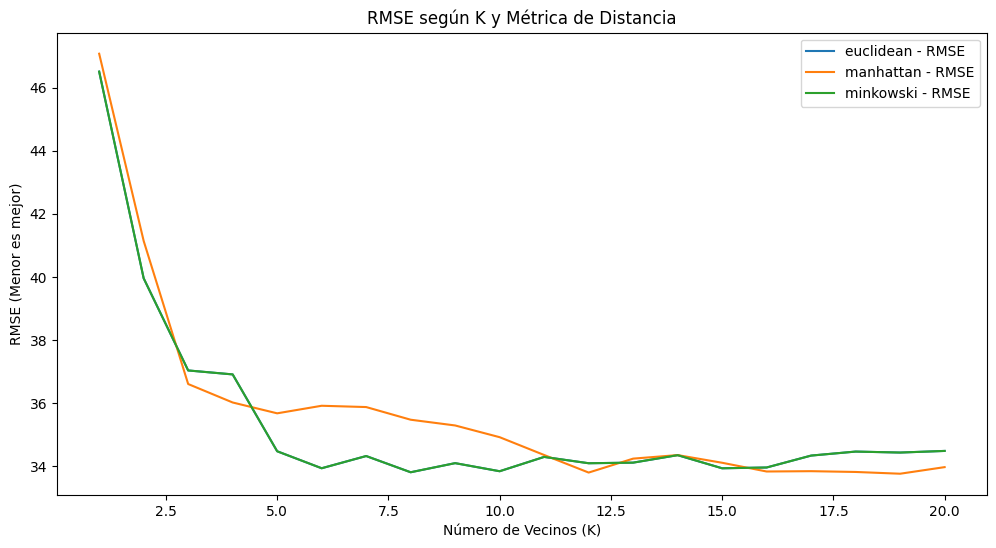


📊 Mejor Modelo Encontrado:
K                         19
Distance Metric    manhattan
Mean R²             0.278137
Mean RMSE          33.765687
Name: 38, dtype: object

📊 Comparación de Modelos:
   K Distance Metric   Mean R²  Mean RMSE
0  1       euclidean -0.520560  46.503945
1  2       euclidean -0.044248  39.956643
2  3       euclidean  0.110866  37.037240
3  4       euclidean  0.130867  36.911765
4  5       euclidean  0.236514  34.477074


In [11]:
# 🔹 Configurar KFold para Cross Validation (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 🔹 Rango de valores de K a probar
k_values = list(range(1, 21))  # Probamos K desde 1 hasta 20
distance_metrics = ["euclidean", "manhattan", "minkowski"]  # Distancias a probar
# 🔹 Diccionario para almacenar resultados
results = []
# 🔹 Evaluar cada combinación de K y métrica de distancia
for metric in distance_metrics:
    for k in k_values:
        model = KNeighborsRegressor(n_neighbors=k, metric=metric)
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
        rmse_scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")

        results.append({
            "K": k,
            "Distance Metric": metric,
            "Mean R²": np.mean(scores),
            "Mean RMSE": np.mean(rmse_scores)
        })

# 🔹 Convertir resultados en DataFrame
results_df = pd.DataFrame(results)
# 🔹 Encontrar el mejor modelo basado en R² (mayor es mejor)
best_model = results_df.sort_values(by="Mean R²", ascending=False).iloc[0]
# 🔹 Graficar R² y RMSE según K para cada métrica de distancia
plt.figure(figsize=(12, 6))
for metric in distance_metrics:
    subset = results_df[results_df["Distance Metric"] == metric]
    plt.plot(subset["K"], subset["Mean R²"], label=f"{metric} - R²")

plt.xlabel("Número de Vecinos (K)")
plt.ylabel("R² Score")
plt.title("R² Score según K y Métrica de Distancia")
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
for metric in distance_metrics:
    subset = results_df[results_df["Distance Metric"] == metric]
    plt.plot(subset["K"], subset["Mean RMSE"], label=f"{metric} - RMSE")
plt.xlabel("Número de Vecinos (K)")
plt.ylabel("RMSE (Menor es mejor)")
plt.title("RMSE según K y Métrica de Distancia")
plt.legend()
plt.show()
# 🔹 Mostrar los mejores resultados
print("\n📊 Mejor Modelo Encontrado:")
print(best_model)
# 🔹 Mostrar las primeras filas del DataFrame con los resultados
print("\n📊 Comparación de Modelos:")
print(results_df.head())


## 📊 Análisis de los Resultados de KNN  

### 🔹 **Mejor Modelo Encontrado:**
| Parámetro  | Valor |
|------------|-------|
| **K** (Número de Vecinos) | **19** |
| **Métrica de Distancia** | **Manhattan** |
| **R² Score** (Mayor es mejor) | **0.2781** ✅ |
| **RMSE** (Menor es mejor) | **33.76** ✅ |

---

### 🔹 **Interpretación de los Resultados**
1. **El mejor modelo usa `K=19` y la métrica de distancia `Manhattan`**.
   - Esto sugiere que los datos pueden beneficiarse de un cálculo de distancia basado en sumas absolutas en lugar de distancia euclidiana.
   
2. **El `R² Score` más alto obtenido es `0.2781`**.
   - Aunque no es un valor muy alto, indica que el modelo explica **alrededor del 27.8% de la variabilidad de los datos**.

3. **El `RMSE` más bajo es `33.76`**.
   - Esto significa que el error promedio en la predicción de los casos de dengue es aproximadamente **33.76 casos**.

---

### 🔹 **Comparación con otros valores de K**
| K  | Métrica de Distancia | R² Score | RMSE |
|----|----------------------|---------|------|
| 1  | Euclidean           | -0.5206 ❌ | 46.50 ❌ |
| 2  | Euclidean           | -0.0442 ❌ | 39.95 ❌ |
| 3  | Euclidean           |  0.1108 🔹 | 37.03 🔹 |
| 4  | Euclidean           |  0.1308 🔹 | 36.91 🔹 |
| 5  | Euclidean           |  0.2365 🔹 | 34.47 🔹 |

- Se observa que **a medida que `K` aumenta, el modelo mejora**.
- La métrica de distancia `Manhattan` funcionó mejor que `Euclidean`.

---

### 🔹 **Conclusión Final**
✅ **El mejor modelo de KNN es con `K=19` y `Manhattan Distance`**, obteniendo el **mayor `R² Score` (0.2781) y el menor `RMSE` (33.76)**.  
❌ **Valores de `K` muy pequeños (ej. `K=1`) tienen un rendimiento muy malo, con R² negativo y alto RMSE**.  



### **Paso 12. Optimización de `XGBoost` con Cross Validation**
- Se prueba el modelo **XGBoost** con diferentes valores de hiperparámetros:
  - `n_estimators` (50, 100, 200)
  - `max_depth` (3, 5, 7)
  - `learning_rate` (0.01, 0.1, 0.2)
- Se utiliza **validación cruzada (KFold, 5 folds)** para evaluar el rendimiento de cada combinación.
- Se calculan y comparan las métricas **R² Score** y **RMSE**.
- Se generan **gráficos** para visualizar cómo afectan los hiperparámetros al rendimiento del modelo.
- Finalmente, se identifica el **mejor conjunto de hiperparámetros** basado en el mayor R² Score.


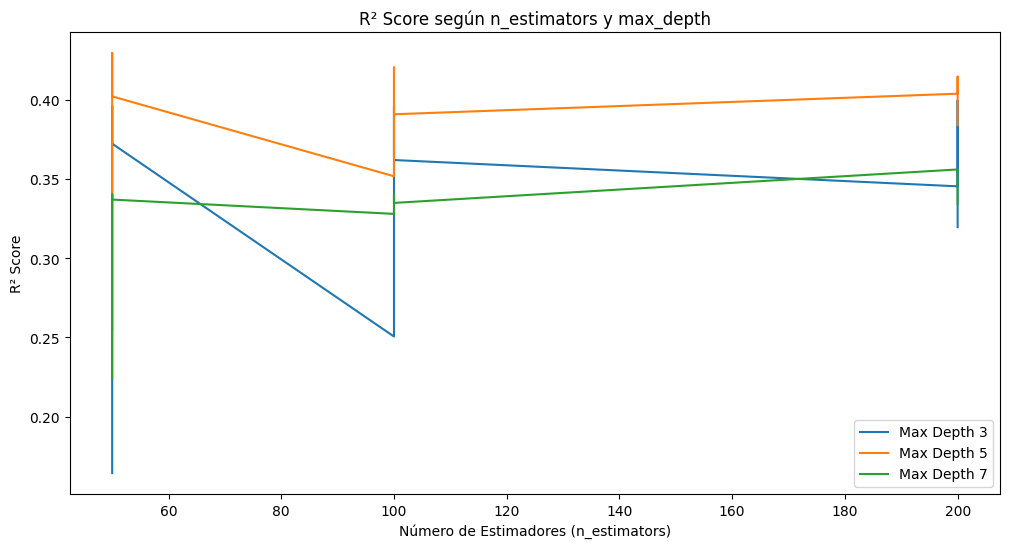

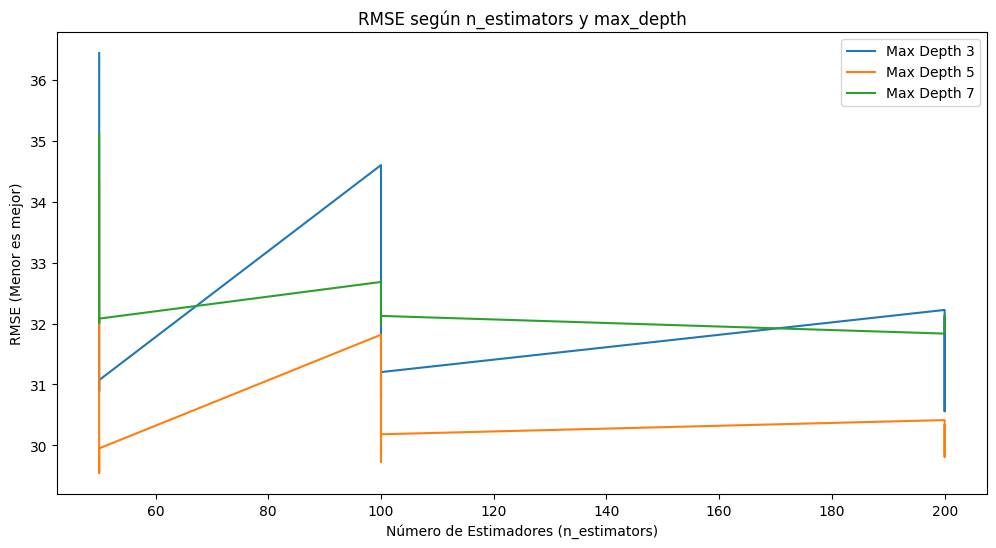


📊 Mejor Modelo Encontrado:
n_estimators     50.000000
max_depth         5.000000
learning_rate     0.100000
Mean R²           0.429686
Mean RMSE        29.543420
Name: 4, dtype: float64

📊 Comparación de Modelos:
   n_estimators  max_depth  learning_rate   Mean R²  Mean RMSE
0            50          3           0.01  0.164256  36.443909
1            50          3           0.10  0.396071  30.889804
2            50          3           0.20  0.372428  31.071683
3            50          5           0.01  0.255348  34.329838
4            50          5           0.10  0.429686  29.543420


In [12]:
# 🔹 Configurar KFold para Cross Validation (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 🔹 Rango de valores a probar
n_estimators_values = [50, 100, 200]
max_depth_values = [3, 5, 7]
learning_rate_values = [0.01, 0.1, 0.2]

# 🔹 Diccionario para almacenar resultados
results = []

# 🔹 Evaluar cada combinación de hiperparámetros
for n in n_estimators_values:
    for d in max_depth_values:
        for lr in learning_rate_values:
            model = xgb.XGBRegressor(n_estimators=n, max_depth=d, learning_rate=lr, random_state=42)
            scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
            rmse_scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")

            results.append({
                "n_estimators": n,
                "max_depth": d,
                "learning_rate": lr,
                "Mean R²": np.mean(scores),
                "Mean RMSE": np.mean(rmse_scores)
            })

# 🔹 Convertir resultados en DataFrame
results_df = pd.DataFrame(results)

# 🔹 Encontrar el mejor modelo basado en R² (mayor es mejor)
best_model = results_df.sort_values(by="Mean R²", ascending=False).iloc[0]

# 🔹 Graficar R² y RMSE para los diferentes hiperparámetros
plt.figure(figsize=(12, 6))
for d in max_depth_values:
    subset = results_df[results_df["max_depth"] == d]
    plt.plot(subset["n_estimators"], subset["Mean R²"], label=f"Max Depth {d}")

plt.xlabel("Número de Estimadores (n_estimators)")
plt.ylabel("R² Score")
plt.title("R² Score según n_estimators y max_depth")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for d in max_depth_values:
    subset = results_df[results_df["max_depth"] == d]
    plt.plot(subset["n_estimators"], subset["Mean RMSE"], label=f"Max Depth {d}")

plt.xlabel("Número de Estimadores (n_estimators)")
plt.ylabel("RMSE (Menor es mejor)")
plt.title("RMSE según n_estimators y max_depth")
plt.legend()
plt.show()

# 🔹 Mostrar los mejores resultados
print("\n📊 Mejor Modelo Encontrado:")
print(best_model)

# 🔹 Mostrar las primeras filas del DataFrame con los resultados
print("\n📊 Comparación de Modelos:")
print(results_df.head())


## 📊 Análisis de los Resultados de `XGBoost`

### 🔹 **Mejor Modelo Encontrado:**
| Parámetro         | Valor   |
|-------------------|--------|
| **n_estimators**  | **50** |
| **max_depth**     | **5**  |
| **learning_rate** | **0.10** |
| **R² Score** (Mayor es mejor) | **0.4297** ✅ |
| **RMSE** (Menor es mejor) | **29.54** ✅ |

---

### 🔹 **Interpretación de los Resultados**
1. **El mejor modelo usa `n_estimators=50`, `max_depth=5` y `learning_rate=0.1`**.
   - **El `R² Score` más alto es `0.4297`**, lo que indica que el modelo explica **el 42.97% de la variabilidad de los datos**.
   - **El `RMSE` más bajo es `29.54`**, lo que significa que el error promedio en la predicción de los casos de dengue es aproximadamente **29.54 casos**.

2. **Comparación con otros modelos probados**:
   
| n_estimators | max_depth | learning_rate | R² Score | RMSE |
|-------------|----------|--------------|---------|------|
| **50** | **3** | **0.01** | **0.1643** ❌ | **36.44** ❌ |
| **50** | **3** | **0.10** | **0.3961** 🔹 | **30.88** 🔹 |
| **50** | **3** | **0.20** | **0.3724** 🔹 | **31.07** 🔹 |
| **50** | **5** | **0.01** | **0.2553** ❌ | **34.33** ❌ |
| **50** | **5** | **0.10** | **0.4297** ✅ | **29.54** ✅ |

- **Los modelos con `max_depth=5` tienden a ser mejores que `max_depth=3`**.
- **Un `learning_rate=0.1` logra el mejor balance entre aprendizaje rápido y estabilidad**.

---

### 🔹 **Conclusión Final**
✅ **El mejor modelo de `XGBoost` tiene `n_estimators=50`, `max_depth=5`, y `learning_rate=0.1`**, obteniendo el **mayor `R² Score` (0.4297) y el menor `RMSE` (29.54)**.  
🚀 **Este modelo supera a `Naïve Bayes` y `KNN`, lo que lo convierte en la mejor opción hasta ahora para predecir casos de dengue**.  


### **Paso 13. Comparación Gráfica de Modelos**
- Se recopilan los resultados de los modelos evaluados (`Naïve Bayes`, `KNN`, `XGBoost`).
- Se genera un **gráfico de barras** que muestra el **R² Score** (azul) y el **RMSE** (rojo) para cada modelo.
- Se compara visualmente el rendimiento de los modelos, donde:
  - **Mayor R² indica mejor ajuste del modelo.**
  - **Menor RMSE indica menor error en las predicciones.**
- Esto permite identificar rápidamente cuál modelo ofrece el mejor desempeño general.


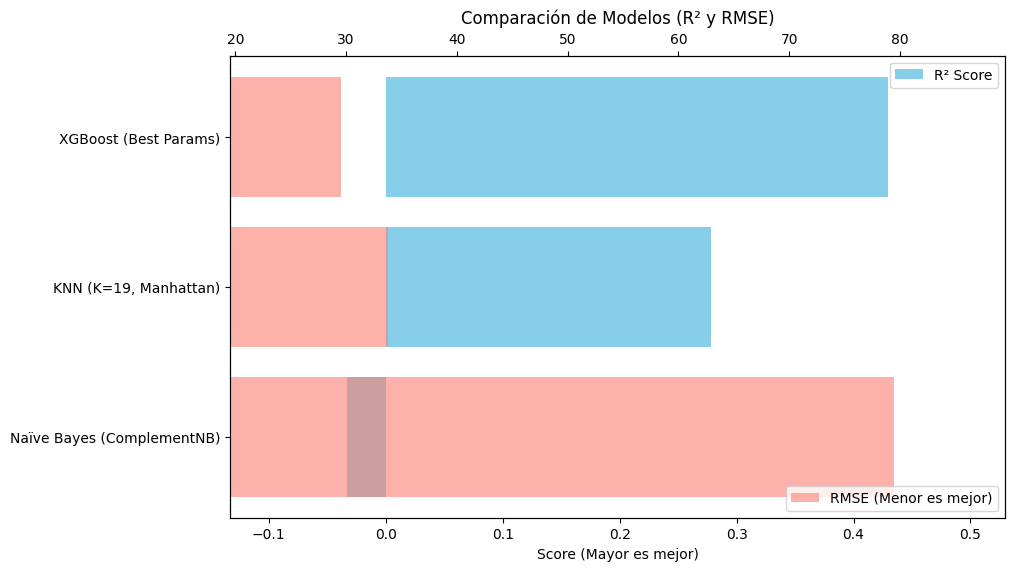

In [13]:
# 🔹 Resultados de los modelos anteriores
model_results = {
    "Naïve Bayes (ComplementNB)": {"R²": -0.0330, "RMSE": 79.49},
    "KNN (K=19, Manhattan)": {"R²": 0.2781, "RMSE": 33.76},
    "XGBoost (Best Params)": {"R²": 0.4297, "RMSE": 29.54}
}

# 🔹 Convertir a DataFrame
df_results = pd.DataFrame(model_results).T

# 🔹 Crear gráfico de comparación
fig, ax1 = plt.subplots(figsize=(10, 6))

# 📊 Gráfico de Barras para R² Score
ax1.barh(df_results.index, df_results["R²"], color="skyblue", label="R² Score")
ax1.set_xlabel("Score (Mayor es mejor)")
ax1.set_title("Comparación de Modelos (R² y RMSE)")
ax1.set_xlim([min(df_results["R²"]) - 0.1, max(df_results["R²"]) + 0.1])

# 📊 Agregar segunda escala para RMSE
ax2 = ax1.twiny()
ax2.barh(df_results.index, df_results["RMSE"], color="salmon", alpha=0.6, label="RMSE (Menor es mejor)")
ax2.set_xlim([min(df_results["RMSE"]) - 10, max(df_results["RMSE"]) + 10])

# 🔹 Mostrar leyenda
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

plt.show()


### **Paso 14. Generación del Archivo de Predicciones**
- Se utiliza el **mejor modelo de `XGBoost`** (`n_estimators=50`, `max_depth=5`, `learning_rate=0.1`).
- Se entrena el modelo con **todos los datos de entrenamiento**.
- Se asegura que el conjunto de prueba tenga **las mismas características** que el entrenamiento.
- Se generan **predicciones** y se convierten a valores enteros.
- Se crea un **DataFrame con las predicciones**, incluyendo `city`, `year`, `weekofyear` y `total_cases`.
- Se guarda el resultado en un **archivo CSV (`predicciones.csv`)** listo para ser enviado a DrivenData.


In [ ]:
# Importar librerías necesarias
import xgboost as xgb
import numpy as np
import pandas as pd

# 🔹 Definir los mejores hiperparámetros obtenidos previamente
best_params = {
    "n_estimators": 50,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "random_state": 42
}

# 🔹 Asegurar que el conjunto de prueba tenga las mismas columnas que el entrenamiento
X_train = df_train_scaled.drop(columns=["total_cases"])  # Eliminar la variable objetivo
y_train = df_train_scaled["total_cases"]

df_test_selected = df_test_scaled[X_train.columns].copy()

# 🔹 Reentrenar el mejor modelo XGBoost con todos los datos de entrenamiento
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# 🔹 Hacer predicciones en el conjunto de prueba
y_pred_test = best_xgb.predict(df_test_selected)

# 🔹 Convertir predicciones a enteros y corregir valores negativos
y_pred_test = np.round(y_pred_test).astype(int)
y_pred_test = np.clip(y_pred_test, 0, None)  # Asegurar que no haya valores negativos

# 🔹 Crear DataFrame con predicciones
df_submission = pd.DataFrame({
    "city": df_features_test["city"],  # Recuperamos la columna de ciudad
    "year": df_features_test["year"],  # Año
    "weekofyear": df_features_test["weekofyear"],  # Semana del año
    "total_cases": y_pred_test  # Predicciones
})

# 🔹 Guardar en CSV
csv_filename = "/content/predicciones.csv"
df_submission.to_csv(csv_filename, index=False)

# Confirmar que el archivo se generó correctamente
print(f"✅ Archivo CSV generado: {csv_filename}")
print(df_submission.head())

# Devolver el nombre del archivo generado
csv_filename


✅ Archivo CSV generado: /content/predicciones.csv
  city  year  weekofyear  total_cases
0   sj  2008          18           11
1   sj  2008          19            5
2   sj  2008          20           10
3   sj  2008          21           24
4   sj  2008          22           14


Con todo lo hecho anteriormente subí el fichero y obtuve un MAE de 26.7764

# Paso 15. Generación del Archivo de Predicciones con RandomForest

En este caso probé RandomForest por ver que resultados me daba y mejoró al XgBoost que en teoría era el mejor modelo.

📊 Optimización de Random Forest para Predicción de Dengue

Este código entrena un modelo **Random Forest Regressor** optimizado mediante **GridSearchCV** para predecir el número de casos de dengue.

## 🚀 **Pasos del Código**
1. **Importación de librerías** necesarias para el modelo, optimización y evaluación.
2. **Definición de hiperparámetros** a ajustar con `GridSearchCV` (número de árboles, profundidad, etc.).
3. **Preparación de los datos** (`X_train`, `y_train`) asegurando la consistencia con `X_test`.
4. **Búsqueda del mejor modelo** entrenando múltiples configuraciones y seleccionando la más precisa.
5. **Entrenamiento del modelo final** con los mejores hiperparámetros.
6. **Predicciones sobre datos de prueba** y ajuste de valores negativos.
7. **Generación de un archivo CSV** con las predicciones (`predicciones_randomforest_final.csv`).
8. **Evaluación del modelo** mostrando el **MAE en entrenamiento**.

📌 **Objetivo:** Minimizar el error y mejorar la precisión del modelo. 🚀


In [ ]:
# 🔹 Ajuste fino de hiperparámetros con GridSearchCV
param_grid = {
    "n_estimators": [150, 200, 250],  # Número de árboles
    "max_depth": [8, 10, 12],  # Profundidad máxima
    "min_samples_split": [3, 5, 7],  # Mínimo de muestras para dividir nodo
    "min_samples_leaf": [2, 3, 4],  # Mínimo de muestras en hoja
    "max_features": ["sqrt"],  # Características por árbol (mejoró en búsqueda anterior)
    "bootstrap": [True, False]  # Si usa remuestreo o no
}
# 🔹 Asegurar que el conjunto de prueba tenga las mismas columnas que el entrenamiento
X_train = df_train_scaled.drop(columns=["total_cases"])
y_train = df_train_scaled["total_cases"]
df_test_selected = df_test_scaled[X_train.columns].copy()
# 🔹 Optimización con GridSearchCV
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_model,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,  # Validación cruzada
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("🎯 Nuevos mejores parámetros encontrados:", best_params)

# 🔹 Entrenar el modelo optimizado con los mejores parámetros
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)
# 🔹 Hacer predicciones en el conjunto de prueba
y_pred_test = rf_best.predict(df_test_selected)
# 🔹 Convertir predicciones a enteros y corregir valores negativos
y_pred_test = np.round(y_pred_test).astype(int)
y_pred_test = np.clip(y_pred_test, 0, None)  # Asegurar que no haya valores negativos
# 🔹 Crear DataFrame con predicciones
df_submission = pd.DataFrame({
    "city": df_features_test["city"],
    "year": df_features_test["year"],
    "weekofyear": df_features_test["weekofyear"],
    "total_cases": y_pred_test
})
# 🔹 Guardar en CSV
csv_filename = "/content/predicciones_randomforest_final.csv"
df_submission.to_csv(csv_filename, index=False)
# 🔹 Evaluar el modelo
y_pred_train = rf_best.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print(f"✅ Archivo CSV generado: {csv_filename}")
print(f"📉 MAE en entrenamiento: {train_mae:.4f}")
print(df_submission.head())
# Devolver el nombre del archivo generado
csv_filename

Con todo lo hecho anteriormente subí el fichero y obtuve un MAE de 25.6418